In [129]:
# Allow reload of objects
%load_ext autoreload
%autoreload
from pelenet.utils import Utils
from pelenet.experiments.readout import ReadoutExperiment

# Official modules
import numpy as np
import nxsdk.api.n2a as nx
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import os
from time import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Initilizes the experiment and utils
exp = ReadoutExperiment()
utils = Utils.instance()

In [3]:
# Build network
exp.build()

# Get spectral radius
utils.getSpectralRadius(exp.net.initialWeights)

1.665

In [4]:
# Run network
exp.run()

INFO:DRV:  Connecting to 127.0.0.1:44893
INFO:DRV:      Host server up..............Done 0.06s
INFO:DRV:      Encoding axons/synapses.....Done 15.28s
Compiling in directory : /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1587036296.9244823
Include dir is : /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/graph/nxinputgen/../../snips/ -I/home/seq/05-reward/v0.x/pelenet/snips/
Compiling -c /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1587036296.9244823/initnetwork_0_0.c
gcc -Wall -I/home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/graph/nxinputgen/../../snips/ -I/home/seq/05-reward/v0.x/pelenet/snips/ -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -st

INFO:DRV:      Compiling Embedded snips....Done 0.63s
INFO:DRV:      Encoding probes.............Done 3.91ms
INFO:HST:  Using Kapoho Bay serial number 308
INFO:HST:  Args chip=0 cpu=0 /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1587036296.9244823/launcher_chip0_lmt0.bin --chips=2 --remote-relay=0 --epoch=0 
INFO:HST:  Args chip=1 cpu=0 /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1587036296.9244823/launcher_chip1_lmt0.bin --chips=2 --remote-relay=0 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.09s
INFO:DRV:      Configuring registers.......Done 14.37s
INFO:DRV:      Transferring probes.........Done 0.02s
INFO:DRV:      Transferring spikes.........Done 0.04s
INFO:HST:  chip=0 cpu=0 Transfered values 20, 245, 30 
INFO:HST:  chip=1 cpu=0 Transfered values 20, 245, 30 
INFO:HST:  chip=0 cpu=0 Reset current/volt

INFO:HST:  chip=0 cpu=0 Reset current/voltage from time step 3920 to 3950
INFO:HST:  chip=1 cpu=0 Reset functional state at 3950
INFO:HST:  chip=0 cpu=0 Reset functional state at 3950
INFO:HST:  chip=0 cpu=0 Reset current/voltage from time step 4165 to 4195
INFO:HST:  chip=1 cpu=0 Reset current/voltage from time step 4165 to 4195
INFO:HST:  chip=0 cpu=0 Reset functional state at 4195
INFO:HST:  chip=1 cpu=0 Reset functional state at 4195
INFO:HST:  chip=0 cpu=0 Reset current/voltage from time step 4410 to 4440
INFO:HST:  chip=1 cpu=0 Reset current/voltage from time step 4410 to 4440
INFO:HST:  chip=0 cpu=0 Reset functional state at 4440
INFO:HST:  chip=1 cpu=0 Reset functional state at 4440
INFO:HST:  chip=0 cpu=0 Reset current/voltage from time step 4655 to 4685
INFO:HST:  chip=1 cpu=0 Reset current/voltage from time step 4655 to 4685
INFO:HST:  chip=0 cpu=0 Reset functional state at 4685
INFO:HST:  chip=1 cpu=0 Reset functional state at 4685
INFO:HST:  chip=1 cpu=0 Reset current/volt

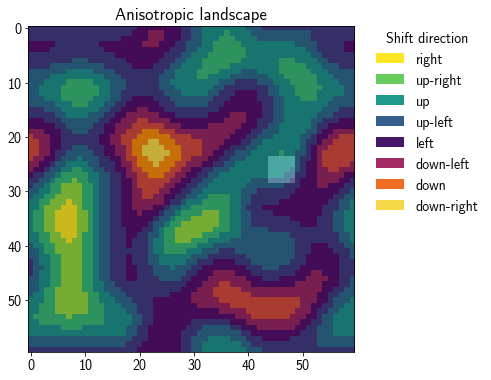

In [5]:
exp.net.plot.landscape()

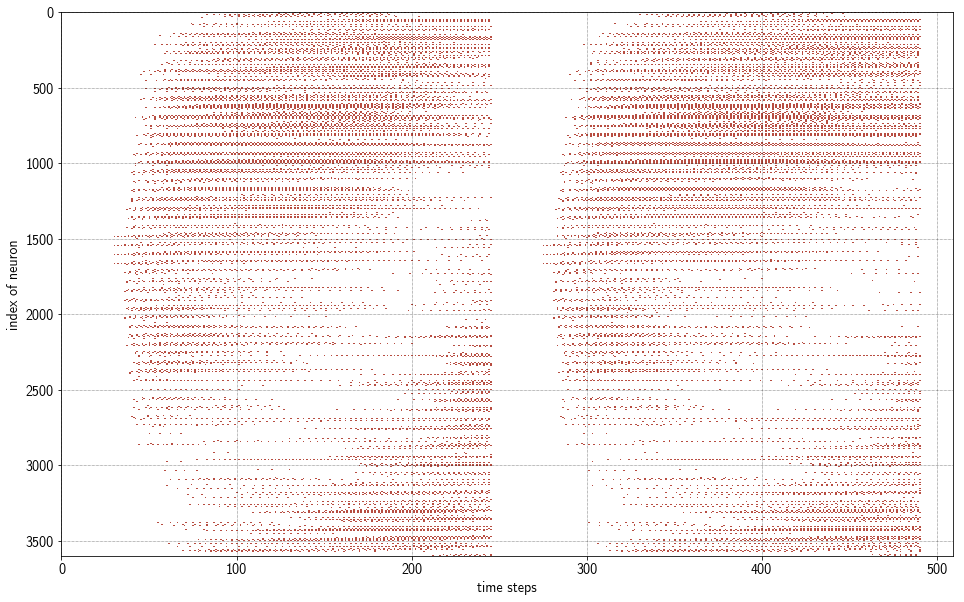

In [18]:
exp.net.plot.reservoirSpikeTrain(fr=0, to=510, figsize=(16,10))

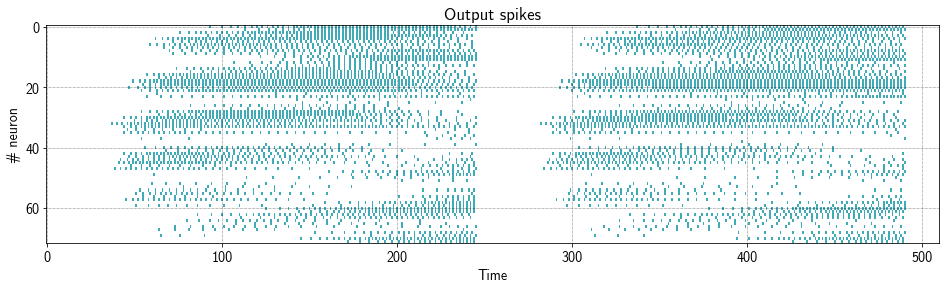

In [19]:
exp.net.plot.outputSpikeTrain(fr=0, to=510, figsize=(16,4))

In [8]:
(x, xe, y) = utils.prepareDataset(exp.net.outSpikeData, exp.target)

In [9]:
x1 = utils.estimateMovement(x, xe, y[0])
x2 = utils.estimateMovement(x, xe, y[1])
x3 = utils.estimateMovement(x, xe, y[2])

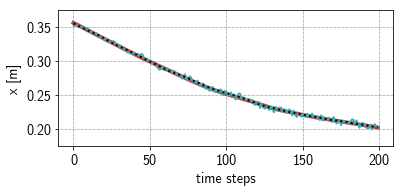

In [134]:
exp.net.plot.movement1D(x1, exp.target[0], dim='x', ylim=(0.175,0.375), figsize=(6,2.5))

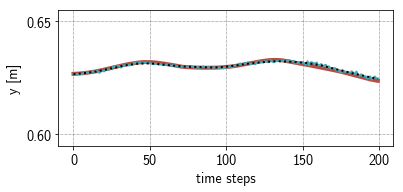

In [135]:
exp.net.plot.movement1D(x2, exp.target[1], dim='y', ylim=(0.595,0.655), figsize=(6,2.5))

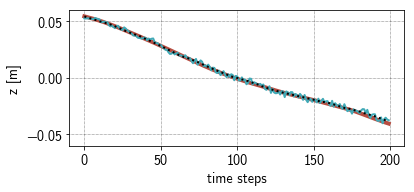

In [136]:
exp.net.plot.movement1D(x3, exp.target[2], dim='z', ylim=(-0.06,0.06), figsize=(6,2.5))

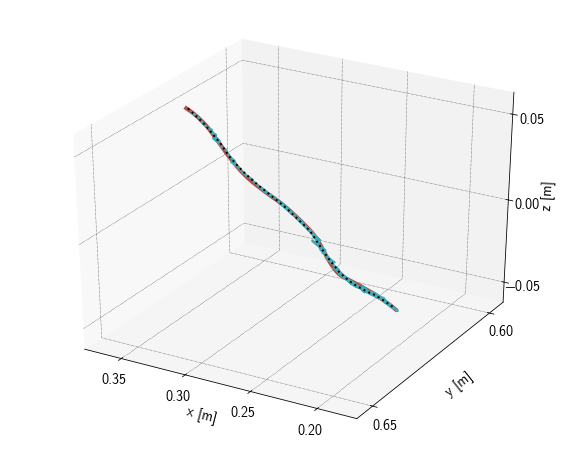

In [139]:
exp.net.plot.movement3D(
    [x1, x2, x3], exp.target, figsize=(10,8),
    xlim=(0.175,0.375), ylim=(0.595,0.655), zlim=(-0.06,0.06)
)

# Differences between two trials

diff01 = np.abs(data[0] - data[2])
p = plt.plot(np.sum(diff01, axis=0))
plt.ylim(0,700)

#plt.figure(figsize=(16, 16))
#p = plt.imshow(diff01)

# Diffs

binSize = 20
bins = np.array([np.mean(data[:, :, i:i+binSize], axis=2) for i in range(0,data.shape[2],binSize)])
bins.shape  # time, trials, neurons

difs = []
for i in range(1,16):
    dif = np.abs(bins[:,i,:] - bins[:,i+1,:])
    difs.append(dif)
difs = np.array(difs)
    
dif_mean = np.sum(difs, axis=(0,2))/3600
dif_sd = np.std(difs, axis=(0,2))

#p = plt.errorbar(dif_mean, yerr=dif_sd)

# PCA

binSize = 10

dtrans = []
for i in range(data.shape[0]):
    dataBinned = np.array([np.mean(data[i, :, j:j+binSize], axis=1) for j in range(0,data[i].shape[1],binSize)])
    (d, evals, evecs) = utils.pca(dataBinned.astype(float), dims_rescaled_data=1)
    dtrans.append(d)

#for i in range(data.shape[0]):

for i in range(25):
    plt.plot(dtrans[i])